# 倒立摆 Pendulum-v0

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import tensorflow as tf
from tensorflow import keras
try: # tf2
    tf.random.set_seed(0)
    from tensorflow.keras.initializers import GlorotUniform
    from tensorflow.keras.optimizers import Adam
except: # tf1
    tf.enable_eager_execution()
    tf.random.set_random_seed(0)
    from tensorflow import glorot_uniform_initializer as GlorotUniform
    from tensorflow.train import AdamOptimizer as Adam
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Pendulum-v0')
env.seed(0)

[0]

用深度确定性策略梯度算法求解

In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['observation', 'action', 'reward',
                'next_observation', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
    
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
        
    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, size, mu=0., sigma=1., theta=.15, dt=.01):
        self.size = size
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.dt = dt
        
    def __call__(self):
        n = np.random.normal(size=self.size)
        self.x += (self.theta * (self.mu - self.x) * self.dt +
                self.sigma * np.sqrt(self.dt) * n)
        return self.x
        
    def reset(self, x=0.):
        self.x = x * np.ones(self.size)

In [5]:
class DDPGAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs,
            replayer_capacity=100000, replayer_initial_transitions=10000,
            gamma=0.99, batches=1, batch_size=64,
            net_learning_rate=0.005, noise_scale=0.1, explore=True):
        observation_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        observation_action_dim = observation_dim + action_dim
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = gamma
        self.net_learning_rate = net_learning_rate
        self.explore = explore
        
        self.batches = batches
        self.batch_size = batch_size
        self.replayer = DQNReplayer(replayer_capacity)
        self.replayer_initial_transitions = replayer_initial_transitions
        
        self.noise = OrnsteinUhlenbeckProcess(size=(action_dim,),
                sigma=noise_scale)
        self.noise.reset()
        
        self.actor_evaluate_net = self.build_network(
                input_size=observation_dim, **actor_kwargs)
        self.actor_target_net = self.build_network(
                input_size=observation_dim, **actor_kwargs)
        self.critic_evaluate_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        self.critic_target_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        
        self.update_target_net(self.actor_target_net,
                self.actor_evaluate_net)
        self.update_target_net(self.critic_target_net,
                self.critic_evaluate_net)
        
    def update_target_net(self, target_net, evaluate_net,
            learning_rate=1.):
        target_weights = target_net.get_weights()
        evaluate_weights = evaluate_net.get_weights()
        average_weights = [(1. - learning_rate) * t + learning_rate * e
                    for t, e in zip(target_weights, evaluate_weights)]
        target_net.set_weights(average_weights)
        
    def build_network(self, input_size, hidden_sizes, output_size=1,
            activation=tf.nn.relu, output_activation=None,
            loss=keras.losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for layer, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape' : (input_size,)} if layer == 0 else {}
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation, 
                    kernel_initializer=GlorotUniform(seed=0), **kwargs))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation,
                kernel_initializer=GlorotUniform(seed=0), ))
        optimizer = Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
    
    def decide(self, observation):
        if self.explore and self.replayer.count < \
                self.replayer_initial_transitions:
            return np.random.uniform(self.action_low, self.action_high)
        
        action = self.actor_evaluate_net.predict(
                observation[np.newaxis])[0]
        if self.explore:
            noise = self.noise()
            action = np.clip(action + noise, self.action_low, self.action_high)
        return action
    
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation,
                done)
        
        if self.replayer.count >= self.replayer_initial_transitions:
            if done:
                self.noise.reset() # 为下一回合重置噪声过程

            for batch in range(self.batches):
                observations, actions, rewards, next_observations, \
                        dones = self.replayer.sample(self.batch_size)

                # 训练执行者网络
                observation_tensor = tf.convert_to_tensor(observations,
                        dtype=tf.float32)
                with tf.GradientTape() as tape:
                    action_tensor = self.actor_evaluate_net(
                            observation_tensor)
                    input_tensor =  tf.concat([observation_tensor,
                            action_tensor], axis=1)
                    q_tensor = self.critic_evaluate_net(input_tensor)
                    loss_tensor = -tf.reduce_mean(q_tensor)
                grad_tensors = tape.gradient(loss_tensor,
                        self.actor_evaluate_net.variables)
                self.actor_evaluate_net.optimizer.apply_gradients(zip(
                        grad_tensors, self.actor_evaluate_net.variables))

                # 训练评论者网络
                next_actions = self.actor_target_net.predict(
                        next_observations)
                observation_actions = np.hstack([observations, actions])
                next_observation_actions = np.hstack(
                        [next_observations, next_actions])
                next_qs = self.critic_target_net.predict(
                        next_observation_actions)[:, 0]
                targets = rewards + self.gamma * next_qs * (1. - dones)
                self.critic_evaluate_net.fit(observation_actions, targets,
                        verbose=0)

                self.update_target_net(self.actor_target_net,
                        self.actor_evaluate_net, self.net_learning_rate)
                self.update_target_net(self.critic_target_net,
                        self.critic_evaluate_net, self.net_learning_rate)

In [6]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation, done)
        if done:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = -44049.12686989993 / 100 = -440.49126869899925


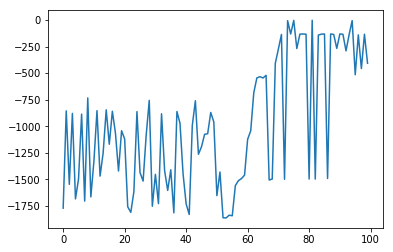

In [7]:
actor_kwargs = {'hidden_sizes' : [32, 64], 'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [64, 128], 'learning_rate' : 0.001}
agent = DDPGAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
agent.explore = False # 取消探索
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

双重延迟深度确定性策略梯度算法

In [8]:
class TD3Agent(DDPGAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs,
            replayer_capacity=100000, replayer_initial_transitions=10000,
            gamma=0.99, batches=1, batch_size=64,
            net_learning_rate=0.005, noise_scale=0.1, explore=True):
        observation_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        observation_action_dim = observation_dim + action_dim
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = gamma
        self.net_learning_rate = net_learning_rate
        self.explore = explore
        
        self.batches = batches
        self.batch_size = batch_size
        self.replayer = DQNReplayer(replayer_capacity)
        self.replayer_initial_transitions = replayer_initial_transitions
        
        self.noise = OrnsteinUhlenbeckProcess(size=(action_dim,),
                sigma=noise_scale)
        self.noise.reset()
        
        self.actor_evaluate_net = self.build_network(
                input_size=observation_dim, **actor_kwargs)
        self.actor_target_net = self.build_network(
                input_size=observation_dim, **actor_kwargs)
        self.critic0_evaluate_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        self.critic0_target_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        self.critic1_evaluate_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        self.critic1_target_net = self.build_network(
                input_size=observation_action_dim, **critic_kwargs)
        
        self.update_target_net(self.actor_target_net,
                self.actor_evaluate_net)
        self.update_target_net(self.critic0_target_net,
                self.critic0_evaluate_net)
        self.update_target_net(self.critic1_target_net,
                self.critic1_evaluate_net)
        
    
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation,
                done)
        
        if self.replayer.count >= self.replayer_initial_transitions:
            if done:
                self.noise.reset()

            for batch in range(self.batches):
                observations, actions, rewards, next_observations, \
                        dones = self.replayer.sample(self.batch_size)

                # 训练执行者
                observation_tensor = tf.convert_to_tensor(observations,
                        dtype=tf.float32)
                with tf.GradientTape() as tape:
                    action_tensor = self.actor_evaluate_net(
                            observation_tensor)
                    input_tensor =  tf.concat([observation_tensor,
                            action_tensor], axis=1)
                    q_tensor = self.critic0_evaluate_net(input_tensor)
                    loss_tensor = -tf.reduce_mean(q_tensor)
                grad_tensors = tape.gradient(loss_tensor,
                        self.actor_evaluate_net.variables)
                self.actor_evaluate_net.optimizer.apply_gradients(zip(
                        grad_tensors, self.actor_evaluate_net.variables))

                # 训练评论者
                next_actions = self.actor_target_net.predict(
                        next_observations)
                observation_actions = np.hstack([observations, actions])
                next_observation_actions = np.hstack(
                        [next_observations, next_actions])
                next_q0s = self.critic0_target_net.predict(
                        next_observation_actions)[:, 0]
                next_q1s = self.critic1_target_net.predict(
                        next_observation_actions)[:, 0]
                next_qs = np.minimum(next_q0s, next_q1s)
                targets = rewards + self.gamma * next_qs * (1. - dones)
                self.critic0_evaluate_net.fit(observation_actions,
                        targets[:, np.newaxis], verbose=0)
                self.critic1_evaluate_net.fit(observation_actions,
                        targets[:, np.newaxis], verbose=0)

                self.update_target_net(self.actor_target_net,
                        self.actor_evaluate_net, self.net_learning_rate)
                self.update_target_net(self.critic0_target_net,
                        self.critic0_evaluate_net, self.net_learning_rate)
                self.update_target_net(self.critic1_target_net,
                        self.critic1_evaluate_net, self.net_learning_rate)

平均回合奖励 = -51667.40034907071 / 100 = -516.6740034907074


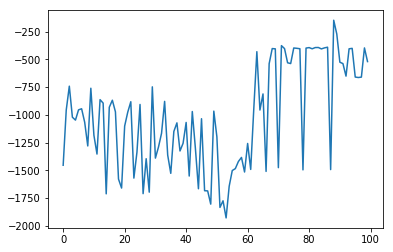

In [9]:
actor_kwargs = {'hidden_sizes' : [32, 64], 'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [64, 128], 'learning_rate' : 0.001}
agent = TD3Agent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
agent.explore = False # 取消探索
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [10]:
env.close()